A question asked on Mastodon made me realize that we don't have a tutorial anywhere on descriptor calculation. Here's a start at that

Do the usual imports

In [1]:
from rdkit import Chem
from rdkit.Chem import Descriptors
import rdkit
rdkit.__version__

'2022.09.1'

A test molecule:

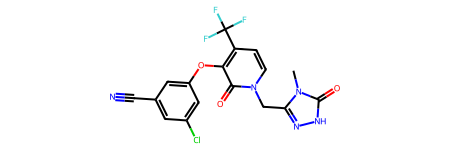

In [3]:
doravirine = Chem.MolFromSmiles('Cn1c(n[nH]c1=O)Cn2ccc(c(c2=O)Oc3cc(cc(c3)Cl)C#N)C(F)(F)F')
doravirine

The `Descriptors` module has a list of the available descriptors. The list is made of (name, function) 2-tuples:

In [2]:
print(len(Descriptors._descList))
print(Descriptors._descList[:5])

208
[('MaxEStateIndex', <function MaxEStateIndex at 0x7f6bfba9e160>), ('MinEStateIndex', <function MinEStateIndex at 0x7f6bfba9e1f0>), ('MaxAbsEStateIndex', <function MaxAbsEStateIndex at 0x7f6bfba9e280>), ('MinAbsEStateIndex', <function MinAbsEStateIndex at 0x7f6bfba9e310>), ('qed', <function qed at 0x7f6bfbab7310>)]


We can use those functions to directly calculate the corresponding descriptor. So, for example, the value of `MaxEStateIndex` for doravirine is:

In [4]:
Descriptors._descList[0][1](doravirine)

13.412553309006833

As an aside, if we just want a few named descriptors, it's a lot clearer (and easier to write the code!) if we call the individual descriptor functions directly:

In [5]:
Descriptors.MaxEStateIndex(doravirine)

13.412553309006833

Often we want to calculate all the descriptors. As of the 2022.09 release of the rdkit there's no real convenience function for descriptor calculation, so let's create one:

In [6]:
def getMolDescriptors(mol, missingVal=None):
    ''' calculate the full list of descriptors for a molecule
    
        missingVal is used if the descriptor cannot be calculated
    '''
    res = {}
    for nm,fn in Descriptors._descList:
        # some of the descriptor fucntions can throw errors if they fail, catch those here:
        try:
            val = fn(mol)
        except:
            # print the error message:
            import traceback
            traceback.print_exc()
            # and set the descriptor value to whatever missingVal is
            val = missingVal
        res[nm] = val
    return res
        

In [7]:
getMolDescriptors(doravirine)

{'MaxEStateIndex': 13.412553309006833,
 'MinEStateIndex': -4.871620672188628,
 'MaxAbsEStateIndex': 13.412553309006833,
 'MinAbsEStateIndex': 0.045220418860841605,
 'qed': 0.6914051268589834,
 'MolWt': 425.754,
 'HeavyAtomMolWt': 414.66600000000005,
 'ExactMolWt': 425.050251552,
 'NumValenceElectrons': 150,
 'NumRadicalElectrons': 0,
 'MaxPartialCharge': 0.4197525104273902,
 'MinPartialCharge': -0.45079941098947357,
 'MaxAbsPartialCharge': 0.45079941098947357,
 'MinAbsPartialCharge': 0.4197525104273902,
 'FpDensityMorgan1': 1.3103448275862069,
 'FpDensityMorgan2': 2.0344827586206895,
 'FpDensityMorgan3': 2.6206896551724137,
 'BCUT2D_MWHI': 35.495691906445956,
 'BCUT2D_MWLOW': 10.182401353178228,
 'BCUT2D_CHGHI': 2.363442602497932,
 'BCUT2D_CHGLO': -2.1532454345808123,
 'BCUT2D_LOGPHI': 2.362094239067197,
 'BCUT2D_LOGPLOW': -2.2620565247489415,
 'BCUT2D_MRHI': 6.30376236817795,
 'BCUT2D_MRLOW': -0.13831572005086737,
 'BalabanJ': 2.1143058157682066,
 'BertzCT': 1236.821427505276,
 'Chi0'

Suppose I want to generate the full set of descriptors for a bunch of molecules...

In [8]:
!head ../data/herg_data.txt

canonical_smiles molregno activity_id standard_value standard_units
N[C@@H]([C@@H]1CC[C@H](CC1)NS(=O)(=O)c2ccc(F)cc2F)C(=O)N3CC[C@H](F)C3 29272 671631 49000 nM
N[C@@H](C1CCCCC1)C(=O)N2CCSC2 29758 674222 28000 nM
N[C@@H]([C@@H]1CC[C@H](CC1)NC(=O)c2ccc(F)c(F)c2)C(=O)N3CCSC3 29449 675583 5900 nM
N[C@@H]([C@@H]1CC[C@H](CC1)NS(=O)(=O)c2ccc(F)cc2F)C(=O)N3CCCC3 29244 675588 35000 nM
N[C@@H]([C@@H]1CC[C@H](CC1)NS(=O)(=O)c2ccc(OC(F)(F)F)cc2)C(=O)N3CC[C@@H](F)C3 29265 679299 6000 nM
N[C@@H]([C@@H]1CC[C@H](CC1)NS(=O)(=O)c2ccc(F)cc2F)C(=O)N3CC[C@@H](F)C3 29253 679302 52000 nM
N[C@@H]([C@@H]1CC[C@H](CC1)NC(=O)c2ccc(F)c(F)c2)C(=O)N3CCCC3 29482 683566 29000 nM
N[C@@H]([C@@H]1CC[C@H](CC1)NC(=O)c2ccccc2C(F)(F)F)C(=O)N3CCSC3 29340 685042 39000 nM
N[C@@H]([C@@H]1CC[C@H](CC1)NC(=O)OCc2ccccc2)C(=O)N3CC[C@@H](F)C3 29213 685047 43000 nM



We can read in all the molecules using a "Supplier" object, there's more about this [in the documentation](https://www.rdkit.org/docs/GettingStartedInPython.html#reading-sets-of-molecules)

In [10]:
suppl = Chem.SmilesMolSupplier('../data/herg_data.txt')
mols = [m for m in suppl]
len(mols)

1090

Now calculate the descriptors

In [11]:
allDescrs = [getMolDescriptors(m) for m in mols]

The problem here is that we have a list of dictionaries... that's not useful for most things. Let's convert it to a pandas dataframe:

In [12]:
import pandas as pd
df = pd.DataFrame(allDescrs)
df.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,13.787943,-4.120373,13.787943,0.074317,0.759946,419.469,395.277,419.149047,156,0,...,0,1,0,0,0,0,0,0,0,0
1,12.032152,-0.232407,12.032152,0.186944,0.777429,228.361,208.201,228.129634,86,0,...,1,0,0,0,0,0,0,0,0,0
2,13.255664,-1.036185,13.255664,0.017845,0.835147,383.464,360.280,383.147904,142,0,...,1,0,0,0,0,0,0,0,0,0
3,13.787093,-4.072560,13.787093,0.015196,0.786287,401.479,376.279,401.158469,150,0,...,0,1,0,0,0,0,0,0,0,0
4,13.326286,-4.859254,13.326286,0.063966,0.625645,467.485,442.285,467.150190,174,0,...,0,1,0,0,0,0,0,0,0,0


And now we have something that we could use to build models, filter, etc.